## Tutorial: Using gen_ini_full_cv Python Script for Generating Uniformly Distributed Initial Configurations

### Introduction

The gen_ini_full_cv script is a powerful tool designed to generate uniformly distributed initial configurations in a 2D collective variable space. This tutorial will guide you through the process of using this script effectively.


### Usage

The initial_config.py script accepts several command-line arguments to customize the generation process. Be sure to habe the the lammps and plumed reference files.

Here's a breakdown of the available options:

    cv1_bin : Number of bins for the first collective variable (Cv_1).
    cv1_min : Minimum value of Cv_1.
    cv1_max : Maximum value of Cv_1.
    cv2_bin : Number of bins for the second collective variable (Cv_2).
    cv2_min : Minimum value of Cv_2.
    cv2_max : Maximum value of Cv_2.
    --plot : Flag to visualize the generated points.

To execute the script, open a terminal or command prompt and run the following command:

python initial_configs.py 5 -3.14 3.14 5 -3.14 3.14

This will generate 25 initial conviguration equally distributed between -pi to pi in both dimensions


### Functions in initial_config.py

The script leverages several functions from functions_ini_configs.py to accomplish its task. Here's an overview of these functions:

    1. generate_centers: Generates uniformly distributed points in the 2D space.

    2. generate_plumed_input: Generates inputs for plumed for Adaptive Biasing Potential (ADP) simulations using the previously obtained points.

    3. generate_input_files: Generates Lammps input files for ADP simulations using the previously obtained plumed inputs and centers.

    4. generate_production_run: Creates production run folders and moves everything there.

In [4]:
import os
## For test 
# os.system(f'python initial_configs.py 5 -3.14 3.14 5 -3.14 3.14 --plot')

# For production runs of 2500 samples 
#os.system(f'python initial_configs.py 5 -3.14 3.14 5 -3.14 3.14 --plot')

# For production runs of 5000 samples 
#os.system(f'python initial_configs.py 71 -3.14 3.14 5 -3.14 3.14 --plot')


Figure(600x600)

Initial configurations generated successfully.

Plumed input files generated successfully.

Lammps input files generated successfully.

Production run folders generated successfully.

All Done! Thank you!!


0

Initial configurations and lammps files genrated in productions_runs folder. 

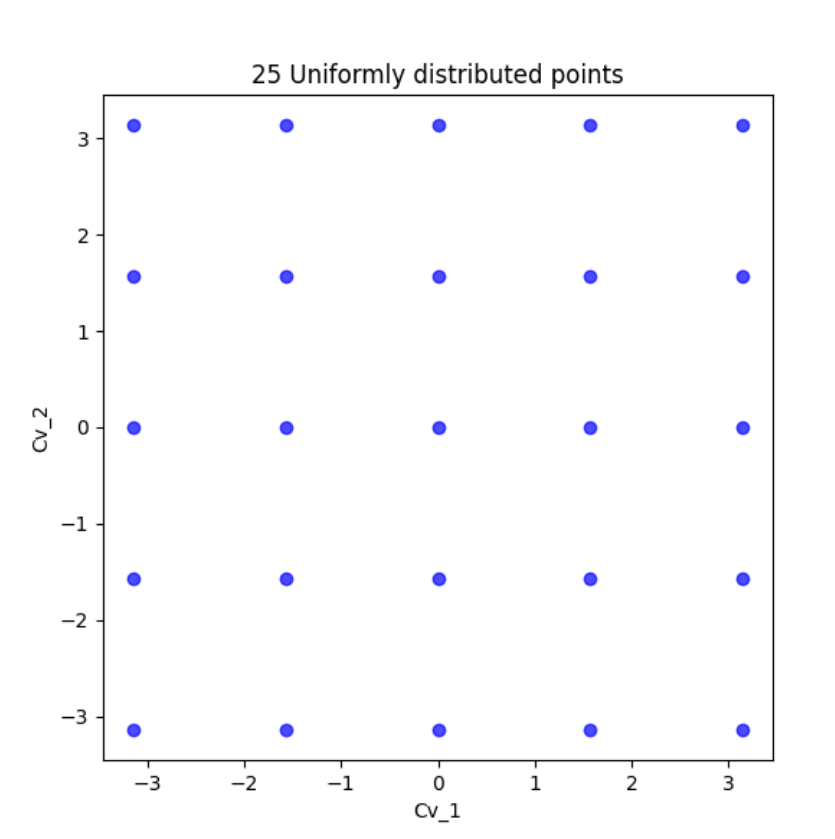


## Selection on initial configurations

This step consist of running a simulation with each of the created initial configuration from each step. THis is achieved using the 'run_cv_config_select_1.py' script. Thi sscript will recreate the referece array from the CVs so make sure to modify the bins and min-max values for each arra, so they mathc the values used in the previous step. Each simulation is ran for 1 ns while the phi and psi values are   (Cvs) are colected, at the end of the simulation the CV values are compared to the reference value. If the error is less that 0.3%, the inthex of the row with the smalles error is stored and the code, continues to the next iterarion. If the error is more than 0.3%, the seed number of the velocity in the lammps imput file is changed, and the process is repeated until the value is obtained..

Finally all the indexes are savet to a file called index_list.txt

In [5]:
# Uncomment for usage 
# os.system('python run_cv_config_select_1.py')


Now that the configurations with the desired CV values has been optained we will proceed to run single point claculations of said configurationsto generate the ADP_Univ training data set. FOr storage purposes the productions_runs folder has been shared as a zip file. 

In [9]:
import numpy as np 
import matplotlib.pyplot as plt
import lammps_logfile as lmplog
import os
import natsort 
from lmp_spc_scripts import read_xyz_traj,xyz_cords_array,lmp_data_subs_coord,change_data_file_name

In [7]:
#Define the names of the files and importatn files to generate the inputs for CLMD SPC. 
data_folder = './destination_path/' #production_runs
# workig_folder = 'umbrella_'
log_file = 'adp_clmd_2ns_umb_' #'log.lammps'
#forces_file = 'forces.dump'
xyz_traj_file = 'traj_nnip.xyz'
lmp_spc_folder = './lmp_spc_2500Frames/'
workig_folder = 'umbrella_'
og_data_file = './example.input'
lmp_input_file = './input_0.inp'
verbose =True

# Load the indices per umbrella or restraint simulation
indices = np.loadtxt('./index_list.txt')


array([ 97., 792., 999., 354., 784.])

In [ ]:
## Check if the lmp_spc_folder exits, if not create it
if not os.path.exists(lmp_spc_folder):
    os.makedirs(lmp_spc_folder)

    i = 1
# Loop over indices from selected 
for i in range(len(indices[:])):
    print(f'\n\nProcessing Umbrella: {i}\n')

    # 1. Determine the working directory.
    working_dir = f'{data_folder}umbrella_{i}/'
    print(f'Working directory: {working_dir}')
    print(f'Index with smallest error is {int(indices[i,0])}')
    print(f'The percentage of the error is {indices[i,1].round(2)} %')


    working_xyz_file = working_dir + xyz_traj_file
    print(f'Working xyz file: {working_xyz_file}')
    # Read the coordinates from the xyz file
    xyz_traj_dict = read_xyz_traj(working_xyz_file)
    # Extract the coordinates from the dictionary
    xyz_coordinates = xyz_cords_array(xyz_traj_dict,int(indices[i,0]))   #xyz_traj_dict['frames'][indices[i]]

    print(f'\nSubstituting coordinates in data file...')

    # Substitute the coordinates in the lammps data file
    lmp_data_subs_coord(xyz_coordinates,og_data_file,f'{lmp_spc_folder}frame_{i}.data',LOUD=False)
    # REname the filename in the read_data command in the lammps input file
    change_data_file_name(f'{lmp_input_file}',f'frame_{i}.data',LOUD=False)


    #3. Create directory to store lammps data and input files.
    os.makedirs(lmp_spc_folder+f'umbrella_{i}', exist_ok=True)
    print(f'Created directory: {lmp_spc_folder}umbrella_{i}\n\n')

    # move the data file to the folder
    os.system(f'mv {lmp_spc_folder}frame_{i}.data {lmp_spc_folder}/umbrella_{i}/')

    # Copy the input file to the folder
    os.system(f'cp {lmp_input_file} ./plumed.dat {lmp_spc_folder}/umbrella_{i}/')


Similarly, for storage efficiency purposes the lmp_spc_2500 folders was also compressed and stored as lmp_spc_2500Frames.zip. The final step is to extract the energies and forces from the SPC lammps logs. 

In [8]:
from lmp_spc_scripts import read_xyz_traj,xyz_cords_array,parse_lammpstrj

## Redefine names of folders 
data_folder = './lmp_spc_2500Frames/'
workig_folder = 'umbrella_'
log_file = 'log.lammps' ##'adp_clmd_2ns_umb_'
forces_file = 'forces.dump'
xyz_traj_file = 'traj_nnip.xyz'


In [ ]:
# TEst for one folder only. 

# Initialize data stofing lists
potEng = []
types = []
coordinates = []
forces = []
cv = []
verbose = True


print(f'Working on {data_folder}')
#Loop over the folders inside the data_folder
for i, umbrella in enumerate(natsort.natsorted(os.listdir(data_folder))[:]):
    if umbrella.startswith(workig_folder): # Enter onfly files that start with umbrella
        if verbose:
            print(f'\n{i}. Umbrella Folder: {umbrella}')
            
        # for config in os.listdir(f'{data_folder}{umbrella}'):
        #     if config.startswith('config_'):
        #         print(f'Config Folder: {config}')
        
        try: #Try block for log file and potential energy
            # Lod the log file and get the potential energy. THen append it to the list
            log = lmplog.File(f'{data_folder}{umbrella}/{log_file}')
            potEng.append(log.get('PotEng')[0])

            if verbose:
                print(f'{data_folder}{umbrella}/{log_file}{i}.log file found.')
                #print(f'Number of frames: {len(log.get("PotEng"))}')
            
        except:
            print(f'No log file found for {data_folder}{umbrella}\n')
            break
        
            
        try: #Try block for coordinate araray. Extract coords from xyz file 
            xyz_traj_dict = read_xyz_traj(f'{data_folder}{umbrella}/{xyz_traj_file}')
            xyz_coordinates = xyz_cords_array(xyz_traj_dict,0)
            coordinates.append(xyz_coordinates)
            
            if verbose:
                print(f'{data_folder}{umbrella}/{xyz_traj_file} file found.')
                #print(f'Number of frames: {len(xyz_traj_dict["frames"])}')
            
        except:
            print(f'No xyz file found for {data_folder}{umbrella}\n')
            break
            
        try: #Block for forces
            forces_dict = parse_lammpstrj(f'{data_folder}{umbrella}/{forces_file}')
            
            # Sort the dictionary by ID, so every frmae is in the same order
            for key in forces_dict.keys():
                forces_dict[key]['atoms'].sort(key=lambda x: x[0])
                
            forces_temp = [] # Iniftialize list to store forces of the cong
            for row in forces_dict[0]['atoms'][:]:
                forces_temp.append(row[-3:])
            
            #Append to genral forces list    
            forces.append(forces_temp)
            if verbose:
                print(f'{data_folder}{umbrella}/{forces_file} forces file found.')
                #print(f'Number of frames: {len(forces_dict)}')
        except:
            print(f'No forces file found for {data_folder}{umbrella}/\n')
            break

        try:
            colvar = np.loadtxt(f'{data_folder}{umbrella}/colvar_multi_0.dat')
            print(f'{data_folder}{umbrella}/colvar_multi_0.dat Colvar file found')
            cv.append(colvar[0])
        except:
            print(f'No colvar file found for {data_folder}{umbrella}/colvar_multi_0.dat\n')
            break        
            
        
    
for atom in xyz_traj_dict['frames'][0]['atoms_data']:
    #types.append(atom['atom_type'])
    #If atom_type =1, 6 or 7 is an Hydrgen atom so append 1
    if (atom['atom_type'] == 1) or (atom['atom_type'] == 6) or (atom['atom_type'] == 7):
        types.append(1)
    #If atom_type =2 or 3 is an Carbon atom so append 6
    elif (atom['atom_type'] == 2) or (atom['atom_type'] == 3):
        types.append(6)
        
    #If atom_type =4  is an Oxygen atom so append 8
    elif (atom['atom_type'] == 4):
        types.append(8)
        
    #If atom_type =5  is an Nitrogen atom so append 7
    elif (atom['atom_type'] == 5):
        types.append(7)
    

#Define type array for the Alanine Dipeptide molecuele. MAke sure follows the same order as the xyz file and the forces file
# type_array = np.array([1,2,1,1,3,4,5,6,2,7,2,1,1,1,3,4,5,6,2,7,7,7])
type_array = np.array(types)
cv = np.array(cv)
# COnvert list into np arrays
potEng = np.array(potEng)
coordinates = np.array(coordinates)
forces = np.array(forces) 



print(f'\nSummary of data:') 
print(f'\nShape of Potential Energy: {np.shape(potEng)}')
print(f'Shape of Coordinates: {np.shape(coordinates)}')
print(f'Shape of Forces: {np.shape(forces)}')
print(f'Shape of Colvar: {np.shape(cv)}')

print(f'Shape of Type Array: {np.shape(type_array)}')

# #Save to npz file
# np.savez(f'{data_folder}alanine_univ2D_CLC_2500frames.npz', E=potEng, R=coordinates, F=forces, z=type_array)
